# Happywhale Camera Viewpoint Classification

This notebook presents the [Happywhale Camera Viewpoint dataset](https://www.kaggle.com/frlemarchand/happywhale-camera-viewpoints), which contains 1680 additional labels. These labels give information on the position of the camera relative to the whales and dolphins in the photos. This can help to know which side of an animal has been photographed. There are 3 possibles labels: port, starboard, unclear.

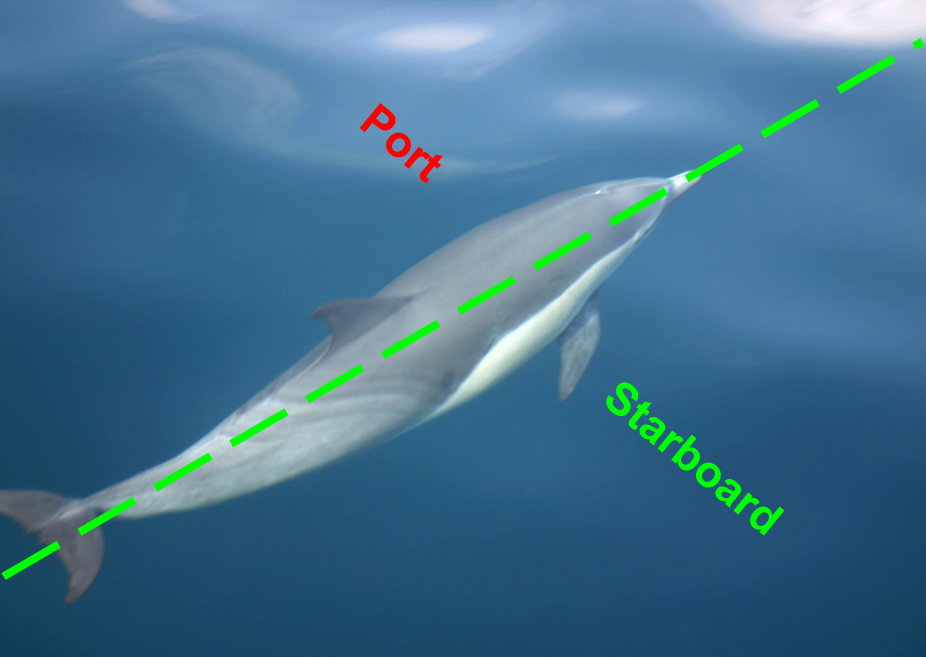

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import cv2
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
training_folder = '../input/whale2-cropped-dataset/cropped_train_images/cropped_train_images/'
df = pd.read_csv("../input/happywhale-camera-viewpoints/camera_viewpoint_labels.csv")
df["filepath"] = training_folder+df["image"]
df = df.dropna()
df

In [ ]:
images = [np.array(Image.open(filename)) for filename in df[:10].filepath.values]
labels = df[:10].label.values

sample_number = len(images)
fig = plt.figure(figsize = (20,sample_number))
for i in range(0,sample_number):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(images[i])
    ax.set_title(str(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
label_dict = {}
for idx, label in enumerate(sorted(df.label.unique())):
    label_dict[label] = idx
df["label"] = [label_dict[label] for label in df["label"]]

In [ ]:
training_percentage = 0.8
training_item_count = int(len(df)*training_percentage)
validation_item_count = len(df)-int(len(df)*training_percentage)
training_df = df[:training_item_count]
validation_df = df[training_item_count:]

In [ ]:
batch_size = 8
image_size = 256
input_shape = (image_size, image_size, 3)
dropout_rate = 0.4
classes_to_predict = sorted(training_df.label.unique())

In [ ]:
training_data = tf.data.Dataset.from_tensor_slices((training_df.filepath.values, training_df.label.values))
validation_data = tf.data.Dataset.from_tensor_slices((validation_df.filepath.values, validation_df.label.values))

In [ ]:
def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    one_hot_label = tf.one_hot(label, len(training_df.label.unique()))
    return img, one_hot_label

AUTOTUNE = tf.data.experimental.AUTOTUNE

training_data = training_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)

In [ ]:
training_data_batches = training_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
validation_data_batches = validation_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
adapt_data = tf.data.Dataset.from_tensor_slices(training_df.filepath.values)
def adapt_mode(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = layers.experimental.preprocessing.Rescaling(1.0 / 255)(img)
    return img

adapt_data = adapt_data.map(adapt_mode, num_parallel_calls=AUTOTUNE)
adapt_data_batches = adapt_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

We'll add some basic augmentation.

In [ ]:
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(height=image_size, width=image_size),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [ ]:
image = Image.open(training_df.iloc[0].filepath)
plt.imshow(image)
plt.show()

In [ ]:
image = tf.expand_dims(np.array(image), 0)

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation_layers(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [ ]:
efficientnet = EfficientNetB0(weights="../input/efficientnet-keras-noisystudent-weights-b0b7/noisystudent/noisy.student.notop-b0.h5", 
                              include_top=False, 
                              input_shape=input_shape, 
                              drop_connect_rate=dropout_rate)

inputs = Input(shape=input_shape)
augmented = data_augmentation_layers(inputs)
efficientnet = efficientnet(augmented)
pooling = layers.GlobalAveragePooling2D()(efficientnet)
dropout = layers.Dropout(dropout_rate)(pooling)
outputs = Dense(len(classes_to_predict), activation="softmax")(dropout)
model = Model(inputs=inputs, outputs=outputs)
    
model.summary()

In [ ]:
%%time
model.get_layer('efficientnetb0').get_layer('normalization').adapt(adapt_data_batches)

In [ ]:
epochs = 25
decay_steps = int(round(len(training_df)/batch_size))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), metrics=["accuracy"])

In [ ]:
history = model.fit(training_data_batches,
                  epochs = epochs, 
                  validation_data=validation_data_batches,
                  callbacks=callbacks)

# Prediction on unlabelled data

Using the trained model, we can now attempt to label the rest of the dataset. Considering that it takes about an hour to annotate 500 images, I am not that keen to spend an additional 100 hours on this.

In [ ]:
training_folder = '../input/whale2-cropped-dataset/cropped_train_images/cropped_train_images/'

test_df = pd.read_csv("../input/happywhale-camera-viewpoints/camera_viewpoint_labels.csv")
test_df["label"] = ["" if pd.isnull(x) else x for x in test_df["label"] ]
test_df["filepath"] = training_folder+test_df["image"]

test_df = test_df.query("label==''")

In [ ]:
test_df

In [ ]:
reverse_label_dict = {'0': 'port','1': 'starboard','2': 'unclear'}
def predict_img(path):
    test_img = np.array(Image.open(path).resize((256,256)))
    predicted_label = reverse_label_dict[str(np.argmax(model.predict(np.array([test_img]))))]
    plt.imshow(test_img)
    plt.show()
    print(predicted_label)

In [ ]:
for i in range(20):
    predict_img(test_df.iloc[i].filepath)

## Thanks for reading this notebook! If you found this notebook helpful, please give it an upvote. It is always greatly appreciated!